In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers

from IPython.display import HTML
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

In [23]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2166 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['Not_Found',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 256, 256, 3)
[1 1 2 2 3 2 1 3 1 2 2 1 2 2 2 1]


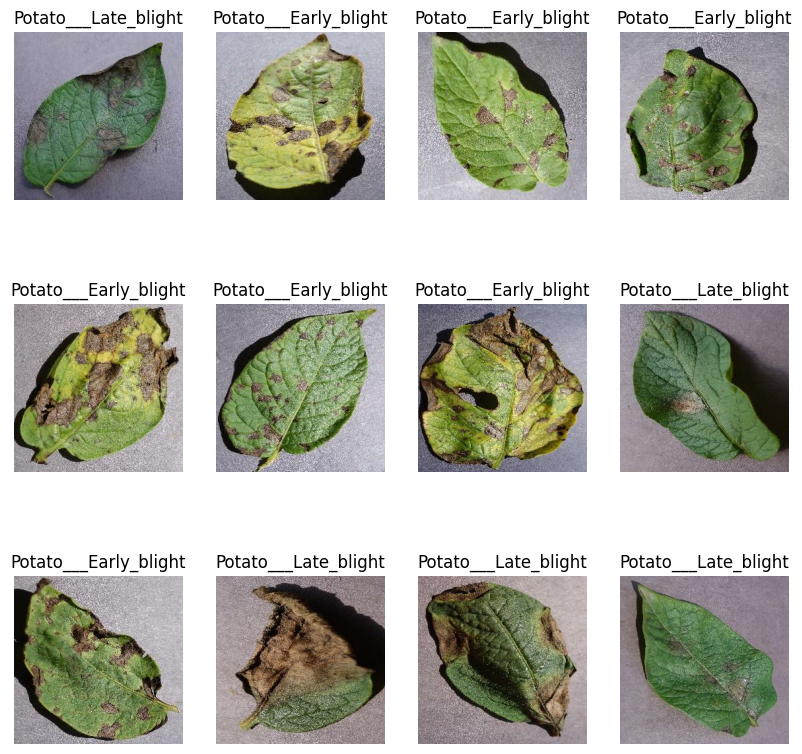

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

136

In [8]:
train_size = 0.6
len(dataset)*train_size

81.6

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

82

In [11]:
val_size=0.25
len(dataset)*val_size

34.0

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

76

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.25, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

81

In [17]:
len(val_ds)

34

In [18]:
len(test_ds)

21

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (16, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (16, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (16, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (16, 60, 60, 64)         

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=16,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


81/81 [==============================] - 25s 272ms/step - loss: 1.0152 - accuracy: 0.4580 - val_loss: 0.9482 - val_accuracy: 0.4596
Epoch 2/50
81/81 [==============================] - 24s 296ms/step - loss: 0.9324 - accuracy: 0.5404 - val_loss: 0.8210 - val_accuracy: 0.7316
Epoch 3/50
81/81 [==============================] - 23s 288ms/step - loss: 0.7715 - accuracy: 0.7053 - val_loss: 0.5985 - val_accuracy: 0.7463
Epoch 4/50
81/81 [==============================] - 24s 290ms/step - loss: 0.5611 - accuracy: 0.8087 - val_loss: 0.4021 - val_accuracy: 0.8382
Epoch 5/50
81/81 [==============================] - 24s 291ms/step - loss: 0.4596 - accuracy: 0.8375 - val_loss: 0.6361 - val_accuracy: 0.7371
Epoch 6/50
81/81 [==============================] - 23s 289ms/step - loss: 0.3947 - accuracy: 0.8577 - val_loss: 0.4417 - val_accuracy: 0.8107
Epoch 7/50
81/81 [==============================] - 24s 294ms/step - loss: 0.3286 - accuracy: 0.8865 - val_loss: 0.2508 - val_accuracy: 0.89

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 106ms/step - loss: 1.0012 - accuracy: 0.8047


In [ ]:
scores

[1.0011622905731201, 0.8046875]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

50

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.0066438913345337,
 0.8717349767684937,
 0.6917563676834106,
 0.47195497155189514,
 0.3821561932563782]

In [ ]:
len(history.history['accuracy'])

50

In [ ]:
history.history['accuracy']

[0.46875,
 0.6354166865348816,
 0.7291666865348816,
 0.8321759104728699,
 0.8674768805503845,
 0.8940972089767456,
 0.9033564925193787,
 0.9068287014961243,
 0.9166666865348816,
 0.9079861044883728,
 0.9288194179534912,
 0.9467592835426331,
 0.9322916865348816,
 0.9247685074806213,
 0.9398148059844971,
 0.9375,
 0.9467592835426331,
 0.9542824029922485,
 0.9554398059844971,
 0.9537037014961243,
 0.9635416865348816,
 0.9716435074806213,
 0.9606481194496155,
 0.9704861044883728,
 0.9664351940155029,
 0.9681712985038757,
 0.9693287014961243,
 0.9774305820465088,
 0.9780092835426331,
 0.9751157164573669,
 0.9780092835426331,
 0.9785879850387573,
 0.984375,
 0.9681712985038757,
 0.9826388955116272,
 0.9820601940155029,
 0.9756944179534912,
 0.9756944179534912,
 0.9722222089767456,
 0.9878472089767456,
 0.9890046119689941,
 0.9930555820465088,
 0.9809027910232544,
 0.9890046119689941,
 0.9890046119689941,
 0.9855324029922485,
 0.9884259104728699,
 0.9930555820465088,
 0.9965277910232544,
 0.9

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 258ms/step
[1.7639009e-06 9.9999160e-01 6.5992831e-06 3.9599959e-11]
predicted label: Potato___Early_blight


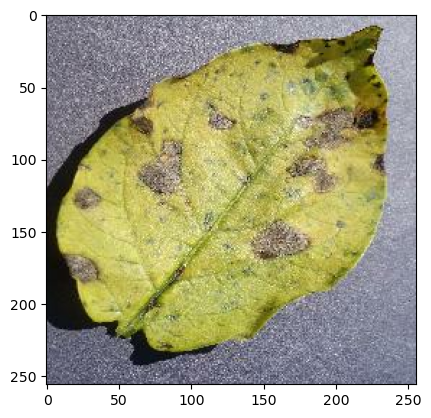

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


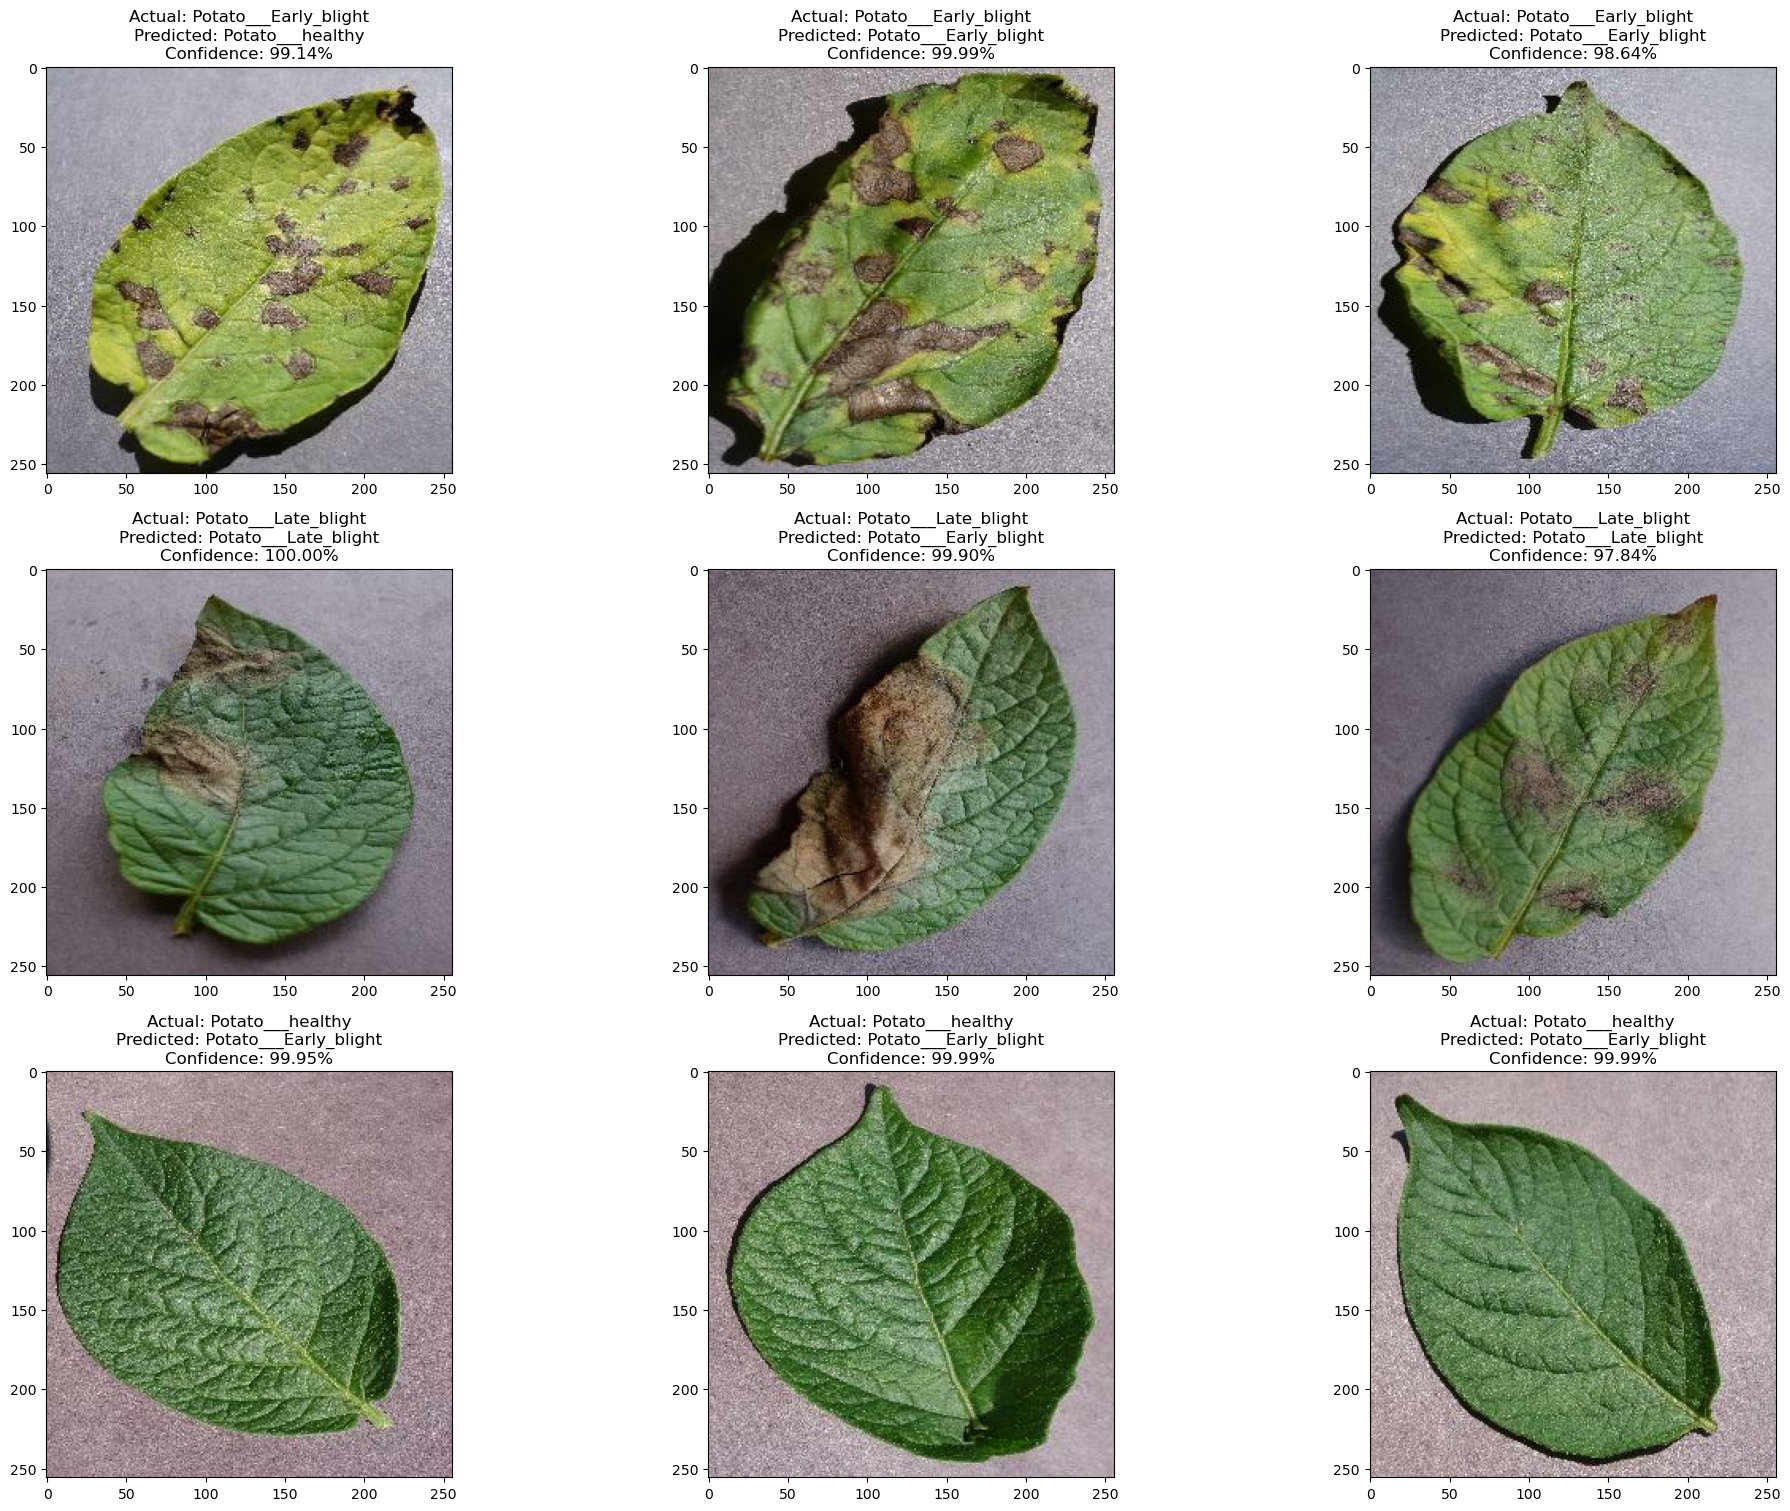

In [ ]:
# Define a list of unique class labels
unique_labels = list(set(class_names))

# Create a figure with 2 rows and 2 columns for each class
plt.figure(figsize=(20, 20))

for label in unique_labels:
    # Filter images and labels for the current class
    images_for_class = []
    labels_for_class = []
    
    for images, labels in test_ds.take(1):
        for i in range(len(labels)):
            if class_names[labels[i]] == label:
                images_for_class.append(images[i].numpy().astype("uint8"))
                labels_for_class.append(labels[i])
    
    # Display up to 3 images for the current class
    for i in range(min(3, len(images_for_class))):
        ax = plt.subplot(4, 3, unique_labels.index(label) * 3 + i + 1)
        plt.imshow(images_for_class[i])
        
        predicted_class, confidence = predict(model, images_for_class[i])
        actual_class = class_names[labels_for_class[i]] 
        
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%")
        
        plt.axis("on")

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 27ms/step


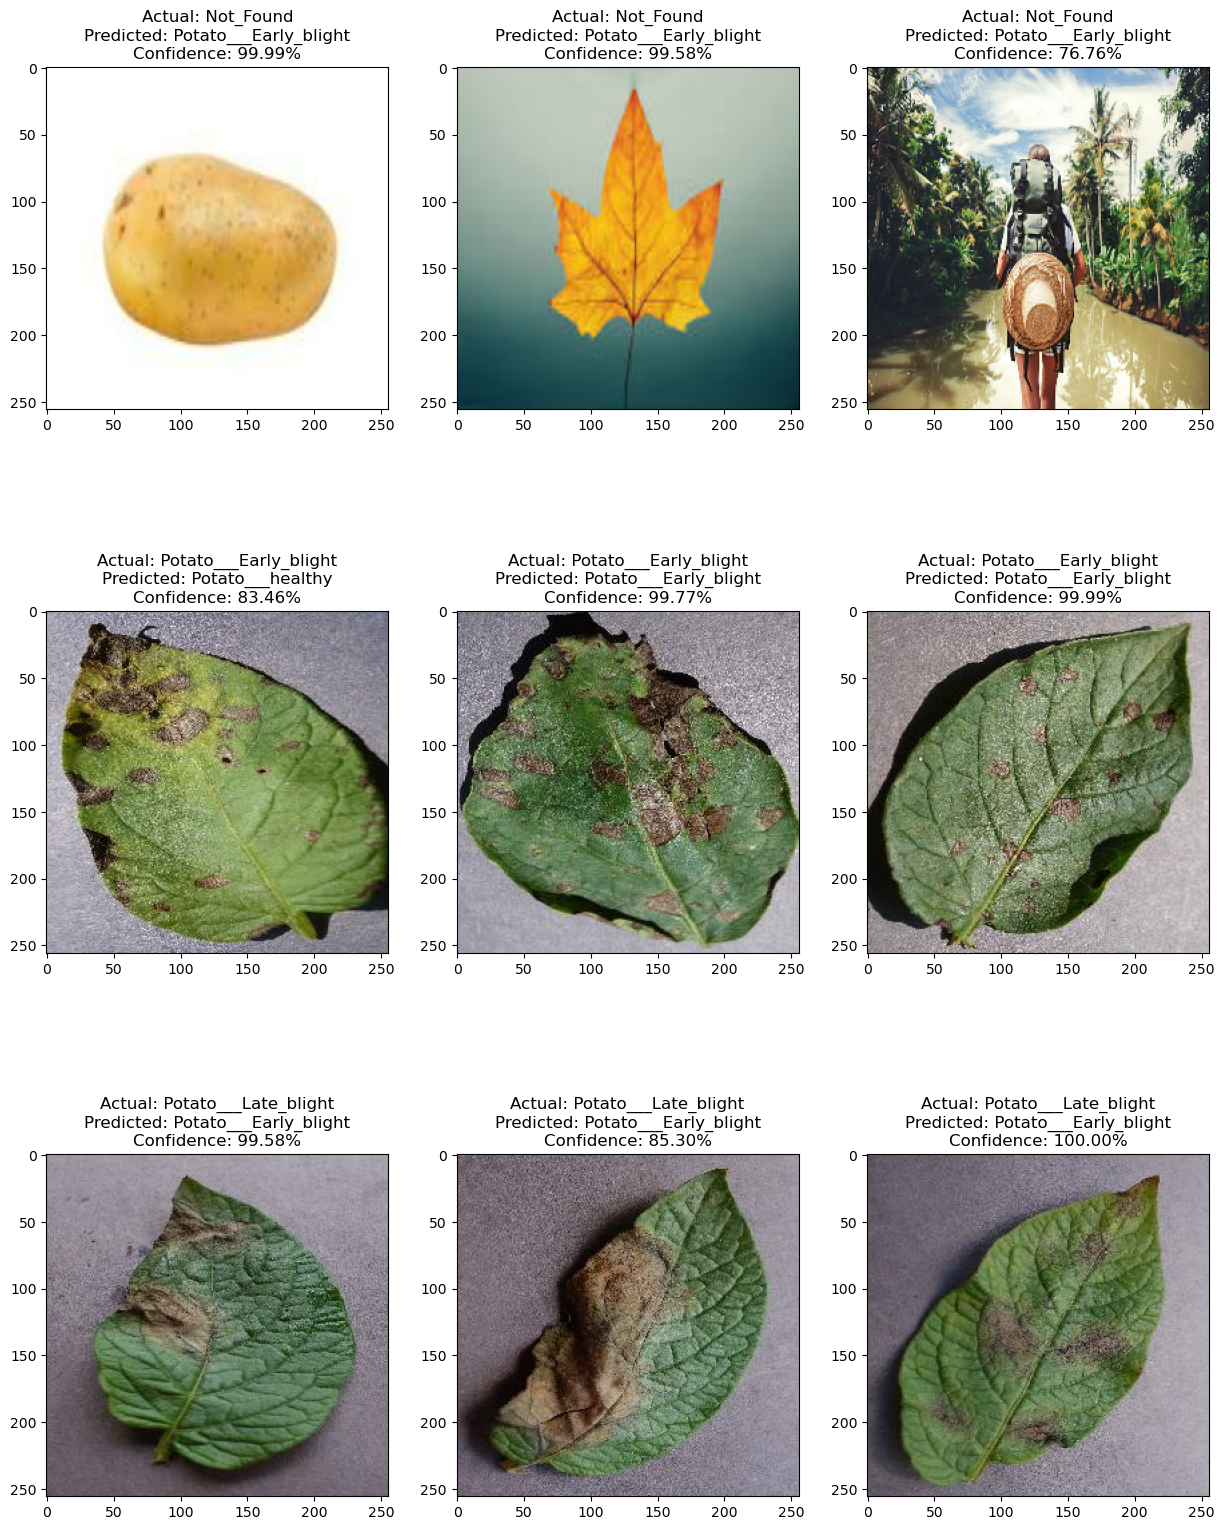

In [ ]:
# Define a list of unique class labels
unique_labels = list(set(class_names))

# Create a figure with 3 rows and 3 columns
plt.figure(figsize=(15,20))

# Define the number of images to display per class
num_images_per_class = 3

# Initialize a counter for each class
class_counters = [0] * len(unique_labels)

# Iterate through the test dataset
for images_batch, labels_batch in test_ds:
    for i in range(len(labels_batch)):
        label = labels_batch[i].numpy()
        image = images_batch[i].numpy().astype("uint8")

        # Check if the label is within the first three classes and the class counter is less than 3
        if label < 3 and class_counters[label] < num_images_per_class:
            # Display the image and its prediction
            ax = plt.subplot(3, 3, label * 3 + class_counters[label] + 1)
            plt.imshow(image)

            predicted_class, confidence = predict(model, image)
            actual_class = class_names[label]

            plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%")
            plt.axis("on")

            # Increment the class counter for the current class
            class_counters[label] += 1

        # Check if we have displayed 3 images for all three classes
        if all(count >= num_images_per_class for count in class_counters[:3]):
            break

    # Check if we have displayed 3 images for all three classes
    if all(count >= num_images_per_class for count in class_counters[:3]):
        break


In [29]:
import os
import pickle

# Get a list of all files in the model directory
model_dir = "../model"
model_files = os.listdir(model_dir)

# Extract the numeric part from the file names and ignore non-numeric files
model_versions = [int(file.split("_")[1].split(".")[0]) for file in model_files if file.startswith("model_")]

# Determine the next model version
next_model_version = max(model_versions, default=0) + 1

# Save the model in saved model format
saved_model_dir = os.path.join(model_dir, f"model_{next_model_version}")
tf.saved_model.save(model, saved_model_dir)

# Save the model as an HDF5 file
hdf5_filename = os.path.join(model_dir, f"model_{next_model_version}.h5")
model.save(hdf5_filename)

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
tflite_filename = os.path.join(model_dir, f"model_{next_model_version}.tflite")
with open(tflite_filename, "wb") as tflite_file:
    tflite_file.write(tflite_model)

# Save the model as a pickle file
pickle_filename = os.path.join(model_dir, f"model_{next_model_version}.pickle")
with open(pickle_filename, "wb") as pickle_file:
    pickle.dump(model, pickle_file)

print("Models saved successfully.")


INFO:tensorflow:Assets written to: ../model\model_5\assets


INFO:tensorflow:Assets written to: ../model\model_5\assets
c:\Users\diwas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Models saved successfully.


In [52]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('model_5.h5')


In [53]:
import tensorflow as tf

# Load the saved Keras model
keras_model = tf.keras.models.load_model('model_5.h5')

# Convert the Keras model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model_5.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\diwas\AppData\Local\Temp\tmp73fq8k_w\assets


INFO:tensorflow:Assets written to: C:\Users\diwas\AppData\Local\Temp\tmp73fq8k_w\assets


In [34]:
# Get the model summary to see the output layer and its shape
model.summary()

# Access the output layer and extract the class names (assuming it's a classification model)
output_layer = model.layers[-1]  # Assuming the output layer is the last layer
class_names = output_layer.get_config()['units']  # Get number of units/classes
print(class_names)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 64)       

In [30]:
model.save("../potatoes.h5")
model.save("../potatoes.tflite")
model.save("../potatoes.pickle")


INFO:tensorflow:Assets written to: ../potatoes.tflite\assets


INFO:tensorflow:Assets written to: ../potatoes.tflite\assets


INFO:tensorflow:Assets written to: ../potatoes.pickle\assets


INFO:tensorflow:Assets written to: ../potatoes.pickle\assets


In [50]:
predicted_labels = [0, 1,2,3,4]  # Example predicted labels


In [45]:
class_names = ["Not Found", "Early", "late", "Healthy","4"]


In [51]:
for label in predicted_labels:
    print(class_names[label])


Not Found
Early
late
Healthy
4


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB7

Pre_Model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(256,256,3))

for layer in Pre_Model.layers:
    layer.trainable = False
x = Pre_Model.output
x = layers.Flatten()(x)
x = layers.Dense(4, activation="relu")(x)
x = layers.Dropout(0.2)(x)

predictions = layers.Dense(3, activation="softmax")(x)

# Create a new model by combining the Pre_Model's input with the modified layers
model_final = models.Model(inputs=Pre_Model.input, outputs=predictions)
model_final.compile(tf.keras.optimizers.SGD(learning_rate=learning_rate),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics =['accuracy'])

history = model_final.fit(train_ds,epochs = 6,verbose = 1, validation_data = val_ds)

In [59]:
epochs=10
learning_rate=0.01
# decay = learning_rate/epochs


In [71]:
from tensorflow.keras.models import load_model

# Load the Keras model (.h5)
model = load_model('final_model.h5')
import tensorflow as tf

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('converted_model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\diwas\AppData\Local\Temp\tmpbephr873\assets


INFO:tensorflow:Assets written to: C:\Users\diwas\AppData\Local\Temp\tmpbephr873\assets
